# Project 1: Web scraping and basic summarization
*University of Ljubljana, Faculty for computer and information science* <br />
*Course: Introduction to data science*

In this Project you need to implement missing parts of this Jupyter notebook. All the code in the notebook must be reproducible and runnable, so include instructions for the environment setup or other specifics needed to run the notebook. The overview of the repository and setup should be put to README.md

The idea of this Project is to automatically retrieve structured data from pages [rtvslo.si](https://www.rtvslo.si) or [24ur.com](https://www.24ur.com). 

## Environment setup

Write instructions how to setup the environment to run this notebook, which libraries are installed, etc. Also provide installation sources.
 This command will run installation for all required packages via conda.
 `conda create --name <env> --file req.txt`

In [1]:
## Load all the libraries needed for running the code chunks below
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
import time
import json
from os import path
from scipy.stats.distributions import norm,expon,gamma
from scipy.stats import norm

In [20]:
# CONSTANTS
WEB_DRIVER_LOCATION = "/home/kavarakis/projects/fri/ids/project-1-Kavarakis-1/chromedriver"
NO_ARTICLES=100
TIMEOUT = 5
filename = 'data.json'
COLLECT_DATA = True

In [21]:
def save_json(data):
    # Check if file exists
    if path.isfile(filename) is False:
        with open(filename, 'w', encoding='utf-8') as outfile:
            json.dump([data],
                      outfile,
                      indent=4,
                      sort_keys=True,
                      ensure_ascii=False)
    else:
        arr = json.load(open(filename))
        with open(filename, 'w', encoding='utf-8') as outfile:
            arr.append(data)
            json.dump(arr,
                      outfile,
                      indent=4,
                      sort_keys=True,
                      ensure_ascii=False)
            del arr
    print('Successfully appended to the JSON file')

In [22]:
def get_comment(url):
    chrome_options = Options()
    chrome_options.add_argument('user-agent=Mozilla/5')
    chrome_options.add_argument('--headless')
    print(f"Retrieving page | URL: {url}")
    driver = webdriver.Chrome(WEB_DRIVER_LOCATION, options=chrome_options)
    driver.get(url)
    time.sleep(TIMEOUT)
    try:
        cookies = driver.find_element(By.XPATH,
                                      '//a[contains(text(),"Strinjam se")]')
        cookies.click()
    except:
        print('Cookies approval failed!')
    time.sleep(2)
    try:
        comms = driver.find_element(By.XPATH,
                                    '//*[@class="link-show-comments"]')
        comms.click()
    except:
        print('Comments cannot be opened!')

    time.sleep(2)
    try:
        while(1):
            show_more = driver.find_element(
                By.XPATH, '//button[contains(text(),"Prikaži več")]')
            show_more.click()
            time.sleep(1)
    except:
        print("Does not have extra comments!")
    time.sleep(2)
    soup = BeautifulSoup(driver.page_source, "html.parser")
    comments = []
    for c in soup.find_all('div', class_='comment'):
        comment_text = ''
        if (c.find('p')):
            comment_text = c.find('p').text
        comment_author = ''
        if (c.find('ul', class_='comment-header-meta-text')):
            comment_author = c.find('ul',
                                    class_='comment-header-meta-text').find(
                                        'a', class_='profile-name').text
        if (comment_text != '' and comment_author != ''):
            comments.append({"user": comment_author, "comment": comment_text})
    driver.close()
    return comments

## Web scraping

News portals generally provide a search functionality to search for news of interest. Your goal is to (a) programatically open a news site (rtvslo.si or 24ur.com), (b) enter query term `koronavirus`, (c) iterate through all the results and (d) parse each news article.

An example of Web pages from rtvslo.si:

<table>
    <tr>
        <td style="text-align: left;">rtvslo.si search results page</td>
        <td style="text-align: left;">rtvslo.si news article page</td>
    </tr>
    <tr>
        <td><img src="./rtvslo1.png" /></td>
        <td><img src="./rtvslo2.png" /></td>
    </tr>
</table>

Export the extracted data in a JSON format. Also define the schema of your data, for example as follows:

```
[
  {
    "type": "news",
    "author": "Ai. Ma.",
    "datetime_published": "20. oktober 2021 22:53 CET",
    "title": "Lejko Zupanc: Starost ljudi, ki potrebujejo najbolj invazivno podporo, se znižuje",
    "subtitle": "Pogovor s strokovnjakinjo v Odmevih",
    "headline": "Strokovnjaki se bojijo mrzlih in prazničnih dni, ko se bodo ljudje več družili v zaprtih prostorih in manj prezračeva...",
    "content": "Podatki o širjenju virusa niso dobri. Kakšne so trenutno razmere na vaši kliniki? 
Trenutne razmere so nekje na robu zmogljivosti, ki smo jih predvideli za covidne bolnike, tako v enoti intenzivne ter ...",
    "tags": ["Novi koronavirus", "Covid-19", "Tatjana Lejko Zupanc"]
    "comments": [
        {
            "user": "anonymous",
            "comment": "Upajmo, da bo vse ok ..."
        }, ...
    ]
    
  }, 
  {
    ...
]
```

Schema could be defined also using [JSON Schema guidelines](https://json-schema.org/).

`TODO: definition and short description of JSON data schema of the extracted data.`

Proposed structure of the implementation is below. You can also import code from the accompanying *.py* files in the repository, so the code is clearer or organize code completely by yourself.

In [23]:
def load_page(url):
    page = requests.get(url, headers={'User-Agent': 'Mozilla/5'})
    soup = BeautifulSoup(page.content, "html.parser")
    return soup

In [24]:
# Implement news article page parsing
def parse_news_article(url):
    print(url)

    content = load_page(url)
    try:
        
        data = content.find('div', class_='news-container')
        author_name = data.find('div', class_='author-name').text
        publish_meta = data.find('div', class_='publish-meta').text
        datetime = (publish_meta.strip().splitlines()[0]).replace('ob ', '')
        datetime += ' CET'
        title = data.find('h1').text
        subtitle = data.find('div', class_='subtitle').text
        headline = data.find('p', class_='lead').text
        body = data.find('article', class_='article')
        content = "\n".join([i.text for i in body.find_all('p')])
        footer = data.find('div', class_='article-footer')
        tags = [i.text for i in footer.find_all('a', class_='tag')]
        comments = get_comment(url)
        _dict = {
            "type": "news",
            "author": author_name,
            "datetime_published": datetime,
            "title": title,
            "subtitle": subtitle,
            "headline": headline,
            "content": content,
            "tags": tags,
            "comments": comments
        }
        return _dict
    except AttributeError as err:
        print(f"Error for {url}: ",err)
        return {}

In [25]:
def get_article_links(html):
    links = []
    r = BeautifulSoup(html, "html.parser")
    data = r.find(id='main-cointaner')
    news = r.find_all('div', class_='md-news')
    for art in news:
        res = art.find('a', 'image-link')['href'].strip()
        
        if res == 'https://www.rtvslo.si/zdravje/novi-koronavirus':
            return []
        res = 'https://www.rtvslo.si' + res
        links.append(res)
    return links

In [26]:
def get_links(url='https://www.rtvslo.si'):
    links = []
    chrome_options = Options()
    chrome_options.add_argument('user-agent=Mozilla/5')
    chrome_options.add_argument("window-size=1200,800")
    print(f"Retrieving page | URL: {url}")

    driver = webdriver.Chrome(WEB_DRIVER_LOCATION, options=chrome_options)
    driver.get(url)
    time.sleep(2)
    try:
        cookies = driver.find_element(By.XPATH,
                                      '//a[contains(text(),"Strinjam se")]')
        cookies.click()
    except:
        print('Cookies approval failed!')
    time.sleep(2)
    _input = driver.find_element_by_id('header-search-input')
    _input.send_keys("koronavirus")
    _input.submit()
    i=0
    while (1):

        links += get_article_links(driver.page_source)
        plinks = driver.find_elements_by_xpath('//a[@class="page-link"]')
        page_link_texts = driver.find_elements_by_xpath(
            '//span[@class="sr-only"]')
        if page_link_texts.pop().text == 'Nazaj':
            break
        if(i>NO_ARTICLES):
            break
        plinks.pop().click()
        time.sleep(1)
        if(i%10 == 0):
            print('links:', len(links))
        i+=10
    driver.close()
    return links

In [27]:
# Implement parsing, data merging and final representation

def search():
    links = get_links()
    print(f'Retrieved {len(links)} links!')
    data = []
    for i,l in enumerate(links):
        print(f"Getting data for: {l}")
        _dict = parse_news_article(l)
        save_json(_dict)
        if i%10 == 0:
            print(f"{i} articles scraped.")
            
    return json.load(open(filename))

In [29]:
# Main program and data export into a JSON
if COLLECT_DATA:
    data = search()
    # Save data to UTF-8 encoded JSON


Retrieving page | URL: https://www.rtvslo.si
links: 0
links: 10
links: 20
links: 30
links: 40
links: 50
links: 60
links: 70
links: 80
links: 90
links: 100
Retrieved 110 links!
Getting data for: https://www.rtvslo.si/zdravje/novi-koronavirus/carotta-ceprav-so-maksimalno-obremenjeni-zdravstveni-delavci-prejemajo-stevilne-groznje/601453
https://www.rtvslo.si/zdravje/novi-koronavirus/carotta-ceprav-so-maksimalno-obremenjeni-zdravstveni-delavci-prejemajo-stevilne-groznje/601453
Retrieving page | URL: https://www.rtvslo.si/zdravje/novi-koronavirus/carotta-ceprav-so-maksimalno-obremenjeni-zdravstveni-delavci-prejemajo-stevilne-groznje/601453
Does not have extra comments!
Successfully appended to the JSON file
0 articles scraped.
Getting data for: https://www.rtvslo.si/zdravje/novi-koronavirus/samotestiranje-ucencev-v-solah-vecinoma-steklo-brez-tezav-policija-zaznala-tri-krsitve-javnega-reda/601449
https://www.rtvslo.si/zdravje/novi-koronavirus/samotestiranje-ucencev-v-solah-vecinoma-steklo-br

Retrieving page | URL: https://www.rtvslo.si/svet/s-in-j-amerika/ameriska-olimpijka-sunisa-lee-zrtev-rasisticnega-napada-s-solzivcem/600928
Does not have extra comments!
Successfully appended to the JSON file
Getting data for: https://www.rtvslo.si/zdravje/novi-koronavirus/danska-znova-uvedla-uporabo-covidnega-potrdila-na-hrvaskem-pogoj-pct-za-drzavni-in-javni-sektor/600899
https://www.rtvslo.si/zdravje/novi-koronavirus/danska-znova-uvedla-uporabo-covidnega-potrdila-na-hrvaskem-pogoj-pct-za-drzavni-in-javni-sektor/600899
Retrieving page | URL: https://www.rtvslo.si/zdravje/novi-koronavirus/danska-znova-uvedla-uporabo-covidnega-potrdila-na-hrvaskem-pogoj-pct-za-drzavni-in-javni-sektor/600899
Does not have extra comments!
Successfully appended to the JSON file
Getting data for: https://www.rtvslo.si/zdravje/novi-koronavirus/ijs-pri-stevilu-potrjenih-okuzb-smo-ze-dosegli-vrhunec-cetrtega-vala/600857
https://www.rtvslo.si/zdravje/novi-koronavirus/ijs-pri-stevilu-potrjenih-okuzb-smo-ze-dose

Retrieving page | URL: https://www.rtvslo.si/slovenija/hojs-protesti-dopustni-ce-so-ustrezno-prijavljeni-in-se-ve-kdo-je-organizator/600286
Does not have extra comments!
Successfully appended to the JSON file
Getting data for: https://www.rtvslo.si/zdravje/novi-koronavirus/avstrija-uvaja-pravilo-pc-in-se-boji-upada-turistov/600284
https://www.rtvslo.si/zdravje/novi-koronavirus/avstrija-uvaja-pravilo-pc-in-se-boji-upada-turistov/600284
Retrieving page | URL: https://www.rtvslo.si/zdravje/novi-koronavirus/avstrija-uvaja-pravilo-pc-in-se-boji-upada-turistov/600284
Does not have extra comments!
Successfully appended to the JSON file
Getting data for: https://www.rtvslo.si/slovenija/pecan-o-obveznem-samotestiranju-znova-so-nas-potisnili-v-prvo-bojno-linijo/600254
https://www.rtvslo.si/slovenija/pecan-o-obveznem-samotestiranju-znova-so-nas-potisnili-v-prvo-bojno-linijo/600254
Retrieving page | URL: https://www.rtvslo.si/slovenija/pecan-o-obveznem-samotestiranju-znova-so-nas-potisnili-v-prvo-

Successfully appended to the JSON file
50 articles scraped.
Getting data for: https://www.rtvslo.si/zdravje/novi-koronavirus/velika-britanija-prva-odobrila-protivirusno-zdravilo-to-je-zgodovinski-dan/599960
https://www.rtvslo.si/zdravje/novi-koronavirus/velika-britanija-prva-odobrila-protivirusno-zdravilo-to-je-zgodovinski-dan/599960
Retrieving page | URL: https://www.rtvslo.si/zdravje/novi-koronavirus/velika-britanija-prva-odobrila-protivirusno-zdravilo-to-je-zgodovinski-dan/599960
Does not have extra comments!
Successfully appended to the JSON file
Getting data for: https://www.rtvslo.si/kultura/vizualna-umetnost/cim-prej-korono-v-muzej-mi-vsi-smo-potencialni-pricevalci-zgodovine/599942
https://www.rtvslo.si/kultura/vizualna-umetnost/cim-prej-korono-v-muzej-mi-vsi-smo-potencialni-pricevalci-zgodovine/599942
Retrieving page | URL: https://www.rtvslo.si/kultura/vizualna-umetnost/cim-prej-korono-v-muzej-mi-vsi-smo-potencialni-pricevalci-zgodovine/599942
Does not have extra comments!
Suc

Does not have extra comments!
Successfully appended to the JSON file
Getting data for: https://www.rtvslo.si/zdravje/novi-koronavirus/v-trstu-do-konca-leta-prepovedani-shodi-na-osrednjem-trgu/599514
https://www.rtvslo.si/zdravje/novi-koronavirus/v-trstu-do-konca-leta-prepovedani-shodi-na-osrednjem-trgu/599514
Retrieving page | URL: https://www.rtvslo.si/zdravje/novi-koronavirus/v-trstu-do-konca-leta-prepovedani-shodi-na-osrednjem-trgu/599514
Does not have extra comments!
Successfully appended to the JSON file
Getting data for: https://www.rtvslo.si/zdravje/novi-koronavirus/tajska-odprla-meje-za-tuje-turiste-avstralija-po-letu-in-pol-dovolila-vstop-drzavljanom/599490
https://www.rtvslo.si/zdravje/novi-koronavirus/tajska-odprla-meje-za-tuje-turiste-avstralija-po-letu-in-pol-dovolila-vstop-drzavljanom/599490
Retrieving page | URL: https://www.rtvslo.si/zdravje/novi-koronavirus/tajska-odprla-meje-za-tuje-turiste-avstralija-po-letu-in-pol-dovolila-vstop-drzavljanom/599490
Does not have extr

Retrieving page | URL: https://www.rtvslo.si/izjava-dneva/leon-cizelj/598612
Does not have extra comments!
Successfully appended to the JSON file
Getting data for: https://www.rtvslo.si/sport/nogomet/nemsko-nogometno-prvenstvo/bayern-s-toppmoellerjem-na-klopi-se-drugic-ta-teden-do-zmage-s-4-0/598593
https://www.rtvslo.si/sport/nogomet/nemsko-nogometno-prvenstvo/bayern-s-toppmoellerjem-na-klopi-se-drugic-ta-teden-do-zmage-s-4-0/598593
Retrieving page | URL: https://www.rtvslo.si/sport/nogomet/nemsko-nogometno-prvenstvo/bayern-s-toppmoellerjem-na-klopi-se-drugic-ta-teden-do-zmage-s-4-0/598593
Does not have extra comments!
Successfully appended to the JSON file
Getting data for: https://www.rtvslo.si/slovenija/preberite-tudi/zorcic-na-konferenci-predsednikov-parlamentov-se-o-pomenu-multilateralizma/598428
https://www.rtvslo.si/slovenija/preberite-tudi/zorcic-na-konferenci-predsednikov-parlamentov-se-o-pomenu-multilateralizma/598428
Retrieving page | URL: https://www.rtvslo.si/slovenija/pr

Retrieving page | URL: https://www.rtvslo.si/zdravje/novi-koronavirus/ce-se-bodo-razmere-se-precej-poslabsale-krek-ne-izkljucuje-nuje-po-dodatnih-ukrepih/597794
Does not have extra comments!
Successfully appended to the JSON file
Getting data for: https://www.rtvslo.si/zdravje/novi-koronavirus/v-petek-potrdili-1437-okuzb-z-novim-koronavirusom-pozitivnih-vec-kot-cetrtina-izvidov-testov/597714
https://www.rtvslo.si/zdravje/novi-koronavirus/v-petek-potrdili-1437-okuzb-z-novim-koronavirusom-pozitivnih-vec-kot-cetrtina-izvidov-testov/597714
Retrieving page | URL: https://www.rtvslo.si/zdravje/novi-koronavirus/v-petek-potrdili-1437-okuzb-z-novim-koronavirusom-pozitivnih-vec-kot-cetrtina-izvidov-testov/597714
Does not have extra comments!
Successfully appended to the JSON file
Getting data for: https://www.rtvslo.si/zdravje/novi-koronavirus/v-zda-priporocilo-za-pozivitveni-odmerek-cepiva-podjetja-johnson-johnson/597713
https://www.rtvslo.si/zdravje/novi-koronavirus/v-zda-priporocilo-za-pozivi

## Basic summarization

Prepare and show at least five basic visualizations of the extracted data as presented in the chapter *Summarizing data - the basics* of the course's e-book. Explain each visualization of the data.

### Data preparation

In [11]:
with open(filename) as output:
    print(len(json.load(output)))

954


In [12]:
data = pd.DataFrame(json.load(open(filename)))
data.head()

,author,comments,content,datetime_published,headline,subtitle,tags,title,type
0,K. T.,[{'comment': 'Tole za Avstrijo je prenapihnjen...,Cilj zaprtja javnega življenja za necepljene j...,15. november 2021 12:05 CET,"V Avstriji, kjer imajo dostop do javnega življ...",V Nemčiji rekordna sedemdnevna incidenca,"[Avstrija, cepljenje, Berlin, ukrepi]","Dva milijona Avstrijcev od doma le v službo, š...",news
1,"La. Da., Al. Ma., G. C.",[],Koordinator bolnišničnih postelj za covid-19 R...,15. november 2021 09:22 CET,"""Če se spomnite petkovih dogodkov pred urgenco...","Potrjenih 1815 okužb, umrlo 11 ljudi","[bolnišnice, covid-19, intenzivna nega]",Carotta: Najboljša bi bila pomoč v kadru iz tu...,news
2,"La. Da., M. Z.",[{'comment': 'Janezovi odgovori: - kriva je op...,Državni zbor je redno novembrsko sejo začel s ...,15. november 2021 07:31 CET,Premier Janez Janša je v odgovoru na poslansko...,Prvi dan 27. redne seje državnega zbora,"[DZ, poslanska vprašanja, epidemija, davki]","Janša o zadržanem odloku, ki uvaja PC-pogoj: ""...",news
3,A. P. J.,"[{'comment': 'Še ena država, ki je zapadla v m...",Dostop do javnih krajev bodo od ponedeljka tak...,14. november 2021 12:58 CET,V Avstriji bo od ponedeljka veljalo zaprtje ja...,Evropa v primežu četrtega vala okužb,"[Avstrija, Nemčija, covid-19, koronavirus]",V Avstriji od ponedeljka zaprtje države samo z...,news
4,G. C.,"[{'comment': 'No, kustec, ti izjemno strokovni...","Ministrstvo za izobraževanje, znanost in šport...",13. november 2021 14:04 CET,Protokol samotestiranja učencev med drugim dol...,"Učenci in dijaki, ki se ne bodo samotestirali,...","[samotestiranje, protokol, šole]",Ministrstvo za izobraževanje šolam posredovalo...,news


In [13]:


data = pd.DataFrame(json.load(open(filename)))
data.head()

# Convert to date time
c = 11
date_map = {}
for i,row in data.iterrows():
    s = row['datetime_published'].split(' ')
    if(s[1]== 'aprile' or s[1] == 'May'):
        c+=1
    if(s[1] in date_map.keys()):
        continue
    else:
        date_map[s[1]] = c
        c-=1
ids = []
for i, row in data.iterrows():
    s = row['datetime_published'].split(' ')
    try:
        
        row['datetime_published'] = pd.to_datetime(f'{s[2]}-{str(date_map[s[1]])}-{s[0]}|{s[3]}',format='%Y-%m-%d.|%H:%M')
    except:
        ids.append(i)
data = data.drop(ids)
data['datetime_published'] = pd.to_datetime(data['datetime_published'])

### Visualization 1
#### Name: Published articles throughout day
This plot shows publish time during day.In this plot we can see that most of the articles are published during start of the day,
in the morning (09:00:00 -09:59:59).

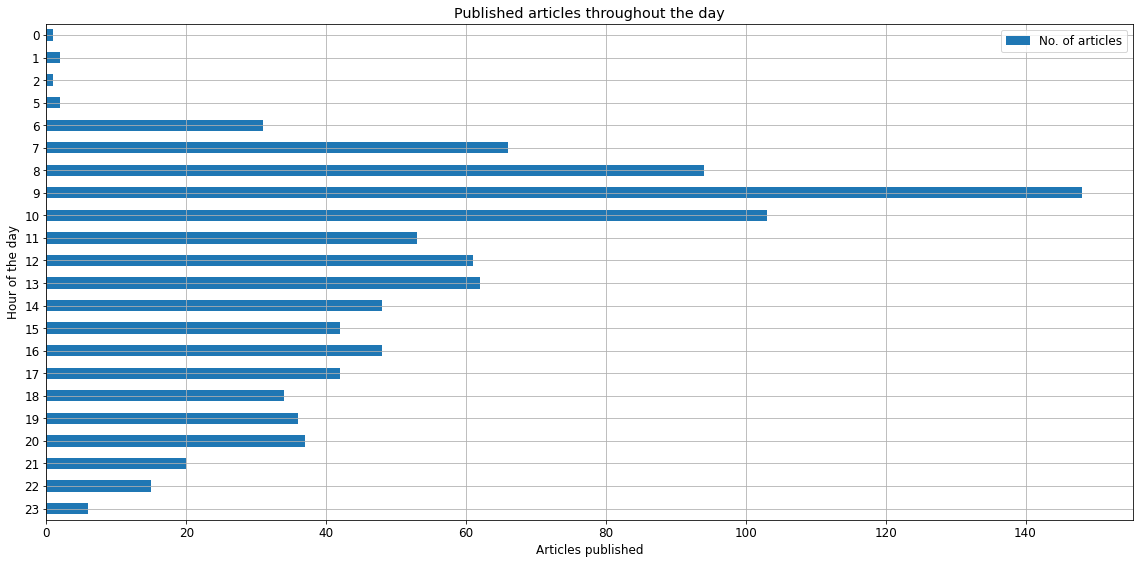

In [14]:
# Visualization 1 code

data['hour'] = data['datetime_published'].dt.hour

plt.rcParams["figure.figsize"] = (16,8)
plt.rcParams["font.size"] = 12

y = data['hour'].value_counts().sort_index(ascending=False).values
x = data['hour'].value_counts().sort_index(ascending=False).index.to_list()
pd.DataFrame({'Hour of the day':x,'No. of articles':y}).plot.barh(x='Hour of the day',y='No. of articles')
plt.grid()
plt.title('Published articles throughout the day')
plt.xlabel('Articles published')
plt.tight_layout()
plt.savefig('viz1.png')

### Visualization 2
#### Name:  Boxplot of article comments by week days
This plot shows distribution of comments by week days. We can see that mean is highest on Sunday (free day), while boxplot is also showing high activity during Mondays.

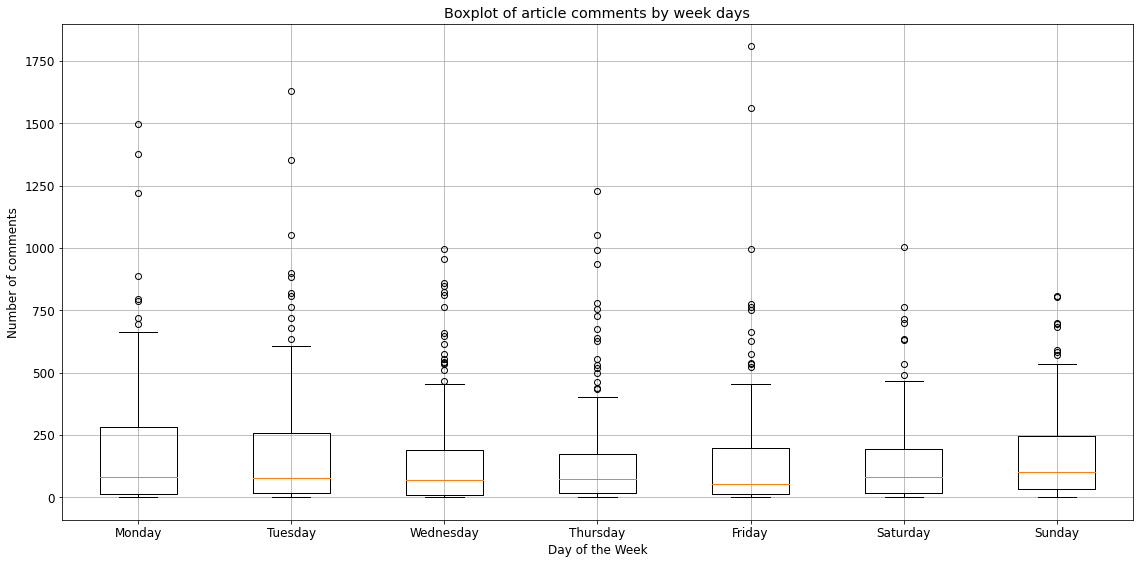

In [15]:
# Visualization 2 code
for i,row in data.iterrows():
    data.at[i,'no_com'] = len(row['comments'])
data['week_day'] = data['datetime_published'].dt.day_name()
g = data.groupby('week_day')['no_com']
val = [str(i) for i in range(7)]
label= [str(i) for i in range(7)]
mapper = {'Monday':0,'Tuesday':1,'Wednesday':2,'Thursday':3,'Friday':4,'Saturday':5,'Sunday':6}
for i,group in g:
    label[mapper[i]]=i
    val[mapper[i]] = (group.values)
plt.rcParams["figure.figsize"] = (16,8)
plt.rcParams["font.size"] = 12
plt.boxplot(val)
plt.xticks(np.arange(1,8), label)
plt.grid()
plt.title('Boxplot of article comments by week days')
plt.xlabel('Day of the Week')
plt.ylabel('Number of comments')
plt.tight_layout()
plt.savefig('viz2.png')
plt.show()

### Visualization 3
#### Name: Distribution of tags during past months
Each article have apropriate tags assigned during creation. We can see that most often number of tags is 3 and that most of the articles in April are having highest number of tags in global.

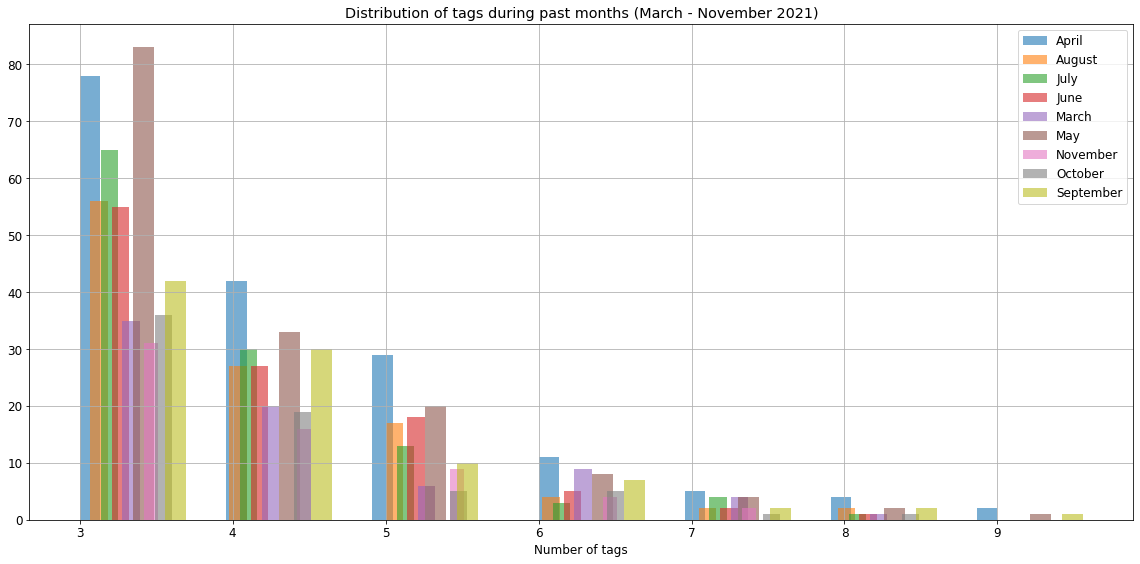

In [16]:
# Visualization 3 code
data['month_name'] = data['datetime_published'].dt.month_name()
g  = data.groupby('month_name')
label = []
val = []
plt.rcParams["figure.figsize"] = (16,8)
plt.rcParams["font.size"] = 12
plt.grid()
plt.xlabel('Number of tags')
plt.title('Distribution of tags during past months (March - November 2021)')
c=0
for i,group in g:
    plt.hist(group['tags'].apply(lambda x: len(x)+c),label=i,bins=round(len(x)*2),alpha=0.6)
    c+=0.07
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('viz3.png')
plt.show()

### Visualization 4

#### Name: Distribution of article content size

Plot is made of two subplots. Right plot represents normalized distribution of content size. Three more distributions are tried for best fit on given data (normal, exponential, gamma). Their Pearson score is given in left subplot.

[-0.59344917 -0.88215813 -0.87784333]


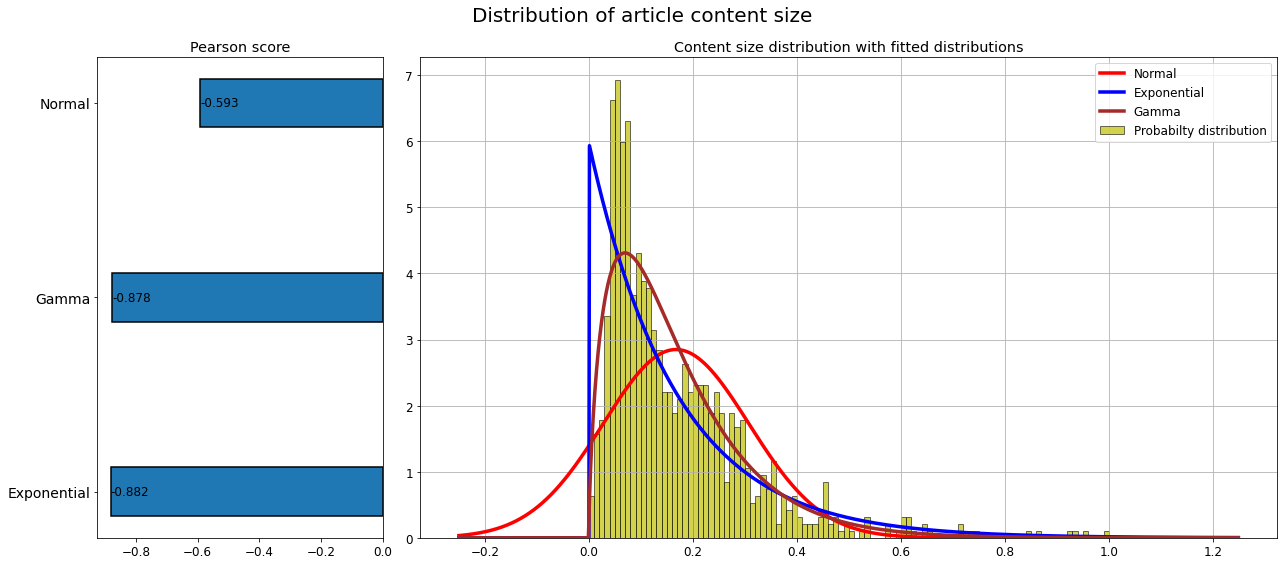

In [17]:
# Visualization 4 code
def normalize(df,col):
    result = df.copy()
    for feature_name in col:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result
data['content_size']= data['content'].apply(lambda x: len(x))
data['com_size']= data['comments'].apply(lambda x: len(x))
data['headline_size']= data['headline'].apply(lambda x: len(x))
data['subtitle_size']= data['subtitle'].apply(lambda x: len(x))
data['title_size']= data['title'].apply(lambda x: len(x))
data['author'] = data['author'].str.lower()
data['week']=data['datetime_published'].dt.dayofweek
data = normalize(data,['content_size','no_com','headline_size','subtitle_size','title_size'])
val = data['content_size'].values
from scipy.stats.distributions import norm,expon,gamma
d = [norm,expon,gamma]

sse = []
attr= []
for i in d:
    attr.append(i)
x = np.arange(-0.25,1.25,1/len(val))
plt.rcParams["figure.figsize"] = [40, 10]
fontsize=12
plt.rcParams["figure.autolayout"] = True
plt.rcParams['font.size']=fontsize
fig,ax = plt.subplots(1,2,figsize=(18,8),gridspec_kw={'width_ratios': [1, 3]})

ax[1].hist(val,bins=100,alpha=0.7,density=True,edgecolor='black',linewidth=0.8,color='y',stacked=True,label='Probabilty distribution')
color=['red','blue','brown']
labels = ['Normal','Exponential','Gamma']
dist = pd.DataFrame()
dist['val']=val
for i,a in enumerate(attr):
    a = d[i].fit(val)
    fitted_data = d[i].pdf(x,*a)
    dist[labels[i]] = d[i].pdf(val,*a)
    ax[1].plot(x,fitted_data,linewidth=3.5,color=color[i],label=labels[i])
    sse.append(np.sum(np.power(val - d[i].pdf(val,*a), 2.0)))
pearson = dist.corr(method='pearson').values[0,1:]
print(pearson)
temp = 0
temp = labels[2]
labels[2] = labels[1]
labels[1] = temp

temp = pearson[2]
pearson[2] = pearson[1]
pearson[1] = temp
bars = ax[0].barh(labels[::-1],pearson[::-1],edgecolor='black',linewidth=1.5,height=0.25)
for bar in bars:
    width = round(bar.get_width(),3) #Previously we got the height
    label_y_pos = bar.get_y() + bar.get_height() / 2
    ax[0].text(width, label_y_pos, s=f'{width}', va='center')
for tick in ax[0].yaxis.get_major_ticks():
    tick.label.set_fontsize(14)

#ax[1].title('Distribution of article content size',fontdict={'fontsize': fontsize})
plt.legend()
fig.suptitle("Distribution of article content size", fontsize=20)
ax[0].title.set_text('Pearson score')
ax[1].title.set_text('Content size distribution with fitted distributions')
ax[1].grid()
plt.tight_layout()
plt.savefig('viz4.png')
plt.show()

### Visualization 5
#### Name: Dependency between title and subtitle size
This plot presents normalized scatter plot of title and subtitle size. Linear regression is fitted on the mentioned data. Besides L.R. curve, 95% confidence intervals (CI) are presented.

In [18]:
corr = data.corr()
corr.style.background_gradient(cmap='coolwarm')


,hour,no_com,content_size,com_size,headline_size,subtitle_size,title_size,week
hour,1.000000,-0.284157,-0.234757,-0.284157,-0.113540,-0.105428,-0.065804,-0.037507
no_com,-0.284157,1.000000,0.421435,1.000000,0.195712,0.079645,0.185954,-0.041795
content_size,-0.234757,0.421435,1.000000,0.421435,0.254481,0.173927,0.266356,-0.048336
com_size,-0.284157,1.000000,0.421435,1.000000,0.195712,0.079645,0.185954,-0.041795
headline_size,-0.113540,0.195712,0.254481,0.195712,1.000000,0.123391,0.285516,0.008378
subtitle_size,-0.105428,0.079645,0.173927,0.079645,0.123391,1.000000,0.152841,-0.025206
title_size,-0.065804,0.185954,0.266356,0.185954,0.285516,0.152841,1.000000,-0.017029
week,-0.037507,-0.041795,-0.048336,-0.041795,0.008378,-0.025206,-0.017029,1.000000


0.8151944183681945 0.10213307883483469 0.6472004532149961


/tmp/ipykernel_89867/4224365849.py:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b--" (-> color='b'). The keyword argument will take precedence.
  plt.plot(x,low,'b--',label=f'Lower confidence limit ({CI*100}%)',color="orange",linewidth=2)
/tmp/ipykernel_89867/4224365849.py:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b--" (-> color='b'). The keyword argument will take precedence.
  plt.plot(x,up,'b--',label=f'Upper confidence limit ({CI*100}%)',color="orange",linewidth=2)


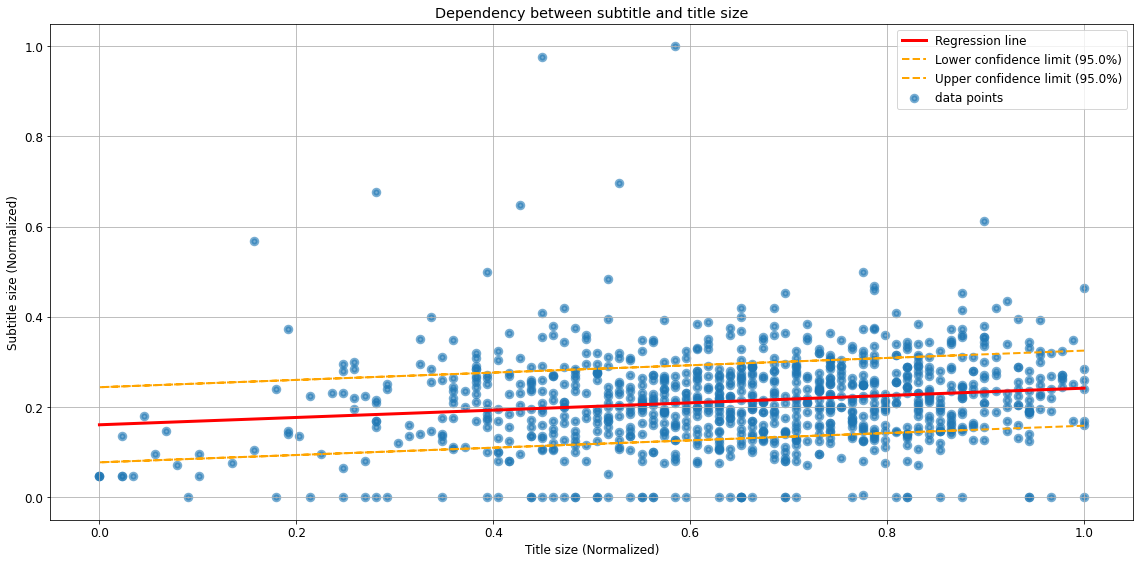

In [19]:
plt.rcParams["figure.figsize"] = (16,8)
plt.rcParams["font.size"] = 12
plt.grid()
x = data['title_size']
y = data['subtitle_size']
z  = np.polyfit(x, y, 1)
p = np.poly1d(z)
fit = p(x)

# get the coordinates for the fit curve
c_y = [np.min(fit),np.max(fit)]
c_x = [np.min(x),np.max(x)]
CI = .95
# predict y values of origional data using the fit
yp = z[0] * x + z[1]
sum_err = np.sum((yp-y)**2)
stdev = np.sqrt(sum_err/(len(y)-2))
z_score = norm.ppf(CI,np.mean(x),stdev)
print(z_score,stdev,np.mean(x))
interval = z_score*stdev
low,up = yp - interval,yp +interval
plt.scatter(x,y,alpha=0.6,linewidths=3.5,label = 'data points')

# plot line of best fit
plt.plot(c_x,c_y,'r-',label='Regression line',linewidth=3)
 
# plot confidence limits
plt.plot(x,low,'b--',label=f'Lower confidence limit ({CI*100}%)',color="orange",linewidth=2)
plt.plot(x,up,'b--',label=f'Upper confidence limit ({CI*100}%)',color="orange",linewidth=2)
 
plt.title('Dependency between subtitle and title size')
plt.xlabel('Title size (Normalized)')
plt.ylabel('Subtitle size (Normalized)')
plt.legend()
plt.tight_layout()
plt.savefig('viz5.png')
plt.show()